# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [9]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [10]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [11]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [12]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [13]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [15]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [16]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [17]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [18]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [19]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [20]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [21]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [22]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [24]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [26]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [27]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [28]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [29]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 160176/160176 [01:11<00:00, 2253.60it/s]


In [30]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [31]:
# preprocessing for review summary.
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)

A classic
Diamond dog food
Essential for Tonkatsu, etc
Better to the last drop


In [32]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

A classic


In [33]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A classic
Diamond dog food
Essential for Tonkatsu, etc
Better to the last drop


In [34]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [35]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Essential for Tonkatsu, etc


In [36]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [37]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Essential for Tonkatsu etc


In [38]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [39]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 160176/160176 [00:51<00:00, 3092.56it/s]


In [40]:
preprocessed_summary[15000]

'favorite tea whole world'

In [41]:
preprocessed_RevSum = preprocessed_reviews+preprocessed_summary

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [42]:
#For Feature Engineering
df1 = pd.DataFrame(preprocessed_RevSum)
docs =preprocessed_RevSum
data = []
for d in docs:
    
    data.append(len(d))

df1['length'] = data
df1.head(5)

,0,length
0,remembered book childhood got kids good rememb...,114
1,daughter loves really rosie books introduced r...,285
2,one best children books ever written mini vers...,144
3,entertaining rhyming story cleaver catchy illu...,142
4,grand daughter favorite book read loves rhythm...,80


In [43]:
df1 = df1.rename(columns = {0 : 'preprocessed_RevSum'})
df1.head(3)

,preprocessed_RevSum,length
0,remembered book childhood got kids good rememb...,114
1,daughter loves really rosie books introduced r...,285
2,one best children books ever written mini vers...,144


In [44]:
X=df1[:100000]
PosNeg = final['Score']
y=PosNeg[:100000]


In [45]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score


In [46]:
# split the data set into train and test
X_1, X_test, y_1, y_test =train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

In [47]:
#performing bow
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(X_tr['preprocessed_RevSum'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_tr['preprocessed_RevSum'].values)
X_cv_bow = vectorizer.transform(X_cv['preprocessed_RevSum'].values)
X_test_bow = vectorizer.transform(X_test['preprocessed_RevSum'].values)

print("After vectorizations")
print(X_train_bow.shape, y_tr.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

(49000, 2) (49000,)
(21000, 2) (21000,)
(30000, 2) (30000,)
After vectorizations
(49000, 30332) (49000,)
(21000, 30332) (21000,)
(30000, 30332) (30000,)


In [62]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)
(30000, 1) (30000,)


*Feature Engineering*


In [63]:
# Feature Engineering
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_bow,X_train_price_norm)).tocsr()
X_cv = hstack((X_cv_bow, X_cv_price_norm)).tocsr()
X_test = hstack((X_test_bow, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


Final Data matrix
(49000, 30383) (49000,)
(21000, 30383) (21000,)
(30000, 30383) (30000,)


In [64]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier




In [65]:
alpha_values = []
powers = [-4,-3,-2,-1,0,1,2,3,4]
for i in powers:
    alpha_values.append(10**i)
print(alpha_values)   

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [73]:
#Finding optimal c using l2 reg.

from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C is %f.' % optimal_alpha)



The optimal C is 0.001000.


In [74]:
#Finding optimal c using l1 reg.
from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l1', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha1 = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C is %f.' % optimal_alpha1)



The optimal C is 0.000100.


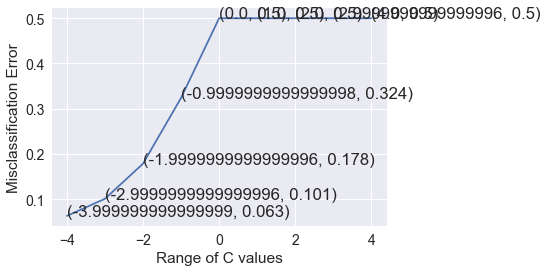

the misclassification error for each C value is :  [0.063 0.101 0.178 0.324 0.5   0.5   0.5   0.5   0.5  ]


In [75]:
import math
alpha = []
for i in alpha_values:
    alpha.append(math.log(i,10))

# plot misclassification error vs alpha
plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Range of C values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

In [84]:
linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier using l2  for C = %f is %f%%' % (optimal_alpha, AUC))


The AUC of the svm classifier using l2  for C = 0.001000 is 95.090284%


In [83]:
linear_svm = SGDClassifier(alpha=optimal_alpha1,penalty='l1', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier using l1 regularization for C = %f is %f%%' % (optimal_alpha1, AUC))


The AUC of the svm classifier using l1 regularization for C = 0.000100 is 93.669809%


* The best/optimal C for BOW using l1 regularization is 0.0001 and its AUC is 93.6%.
* The best/optimal C for BOW using l2 regularization is 0.001 and its AUC is 95.09%.
* Therefore we got better AUC for l2 regularization.

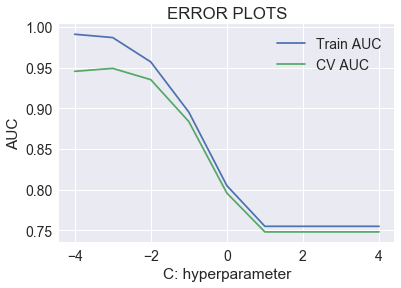

In [78]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3, 10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in C:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm)
    sig_clf.fit(X_tr,y_tr)

    # not the predicted outputs
    y_train_pred =  sig_clf.predict_proba(X_tr)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


import math
alpha = []
for i in C:
    alpha.append(math.log(i,10))

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


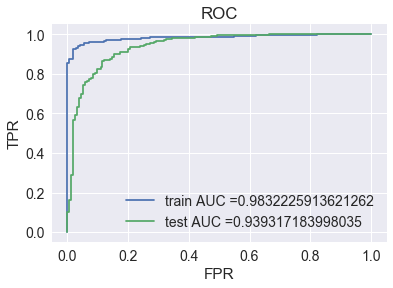

Test confusion matrix
[[ 7184   264]
 [ 3034 38518]]
Test confusion matrix
[[ 3866   637]
 [ 2301 23196]]


In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm)
sig_clf.fit(X_tr,y_tr)


for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], sig_clf.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], sig_clf.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
print(confusion_matrix(y_tr, linear_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, linear_svm.predict(X_test)))


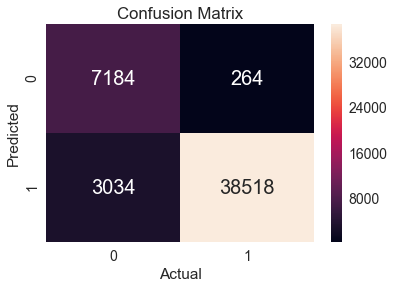

In [80]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, linear_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

*Top 20 feature names of positive class*

In [81]:
#Source:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(linear_svm.coef_[0], feature_names))
top = coefs_with_fns[:-(20 + 1):-1]
print("Top 10 positive features")
for coef_2, fn_2 in top:
    print("%s <------------------------>%s"%(coef_2, fn_2))

Top 10 positive features
1.0053694673823883 <------------------------>not disappointed
0.8338630304815858 <------------------------>delicious
0.7480465255230954 <------------------------>perfect
0.7176690016439936 <------------------------>loves
0.7060242841570484 <------------------------>great
0.7053914190761799 <------------------------>excellent
0.6939998476215378 <------------------------>best
0.6718495697929905 <------------------------>amazing
0.6545090665786738 <------------------------>wonderful
0.6540027745140136 <------------------------>pleased
0.6303336204915465 <------------------------>happy
0.626409856990489 <------------------------>awesome
0.5772995267192615 <------------------------>yummy
0.5454031266461916 <------------------------>beat
0.5422388012421178 <------------------------>hooked
0.5308472297874519 <------------------------>refreshing
0.5271766123187288 <------------------------>not bad
0.5181899281711579 <------------------------>thank
0.5123675694276597 <-

*Top 20 feature names of negative class.*

In [82]:
#Source:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(linear_svm.coef_[0], feature_names))
top = coefs_with_fns[:20]
print("Top 20 negative features")
for coef_1, fn_1 in top:
    print("%s    <---------------->     %s"%(coef_1, fn_1))

Top 20 negative features
-1.0009394118166757    <---------------->     disappointing
-0.9517025085292841    <---------------->     worst
-0.9251221751350613    <---------------->     terrible
-0.8949977972882687    <---------------->     disappointed
-0.8698097670718511    <---------------->     not worth
-0.8400651082735531    <---------------->     awful
-0.7923470811801204    <---------------->     tasteless
-0.7620961303171654    <---------------->     not good
-0.7471605144099457    <---------------->     not happy
-0.6761530523425239    <---------------->     threw
-0.6595719872251764    <---------------->     not recommend
-0.6445097983017842    <---------------->     horrible
-0.6367888443158436    <---------------->     rip
-0.6361559792350258    <---------------->     not buy
-0.6131196902933727    <---------------->     worse
-0.6091959267923202    <---------------->     definitely not
-0.6084364886953376    <---------------->     bland
-0.5814764362526346    <--------------

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [125]:
X=df1[:100000]
PosNeg = final['Score']
y=PosNeg[:100000]

In [126]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [127]:

print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,dtype=np.float64)
tf_idf_vect.fit(X_tr['preprocessed_RevSum'].values)
X_tr_tfidf= tf_idf_vect.transform(X_tr['preprocessed_RevSum'].values)
X_cv_tfidf = tf_idf_vect.transform(X_cv['preprocessed_RevSum'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['preprocessed_RevSum'].values)
print("After vectorizations")
print(X_tr_tfidf.shape, y_tr.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

(49000, 2) (49000,)
(21000, 2) (21000,)
(30000, 2) (30000,)
After vectorizations
(49000, 27952) (49000,)
(21000, 27952) (21000,)
(30000, 27952) (30000,)


In [128]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(49000, 1) (49000,)
(21000, 1) (21000,)
(30000, 1) (30000,)


*Feature Engineering*


In [129]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_tr_tfidf,X_train_price_norm)).tocsr()
X_cv = hstack((X_cv_tfidf, X_cv_price_norm)).tocsr()
X_test = hstack((X_test_tfidf, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


Final Data matrix
(49000, 27953) (49000,)
(21000, 27953) (21000,)
(30000, 27953) (30000,)


In [130]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier




In [131]:
alpha_values = []
powers = [-4,-3,-2,-1,0,1,2,3,4]
for i in powers:
    alpha_values.append(10**i)
print(alpha_values)   

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [137]:
from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C for l2 is %f.' % optimal_alpha)



The optimal C for l2 is 0.000100.


In [133]:
from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l1', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha1 = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C for l1 is %f.' % optimal_alpha1)



The optimal C for l1 is 0.000100.


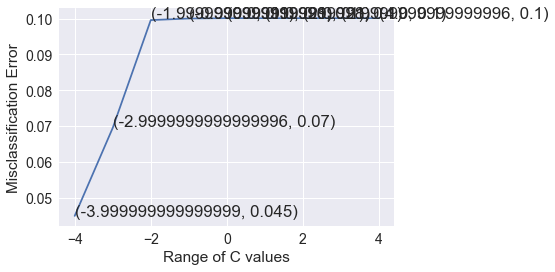

the misclassification error for each C value is :  [0.045 0.07  0.1   0.1   0.1   0.1   0.1   0.1   0.1  ]


In [138]:
import math
alpha = []
for i in alpha_values:
    alpha.append(math.log(i,10))

# plot misclassification error vs alpha
plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Range of C values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

In [139]:
linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier of l2 for C = %f is %f%%' % (optimal_alpha, AUC))


The AUC of the svm classifier of l2 for C = 0.000100 is 95.804539%


In [140]:
linear_svm = SGDClassifier(alpha=optimal_alpha1,penalty='l1', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier of l1 for C = %f is %f%%' % (optimal_alpha1, AUC))


The AUC of the svm classifier of l1 for C = 0.000100 is 94.489139%


* The best/optimal C for TF-IDF using l1 regularization is 0.0001 and its AUC is 94.4%.
* The best/optimal C for TF-IDF using l2 regularization is 0.0001 and its AUC is 95.80%.
* Therefore we got better AUC for l2 regularization

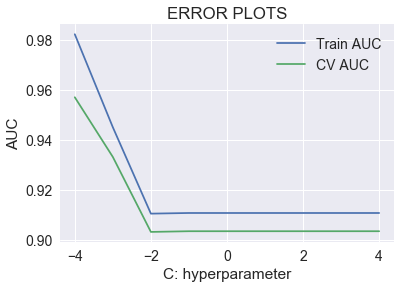

In [110]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3, 10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in C:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm)
    sig_clf.fit(X_tr,y_tr)

    # not the predicted outputs
    y_train_pred =  sig_clf.predict_proba(X_tr)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


import math
alpha = []
for i in C:
    alpha.append(math.log(i,10))

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


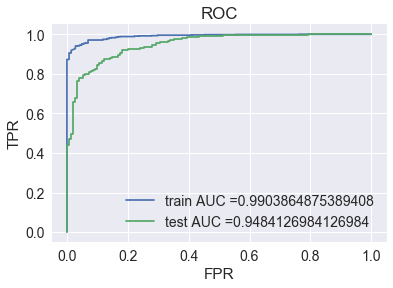

Test confusion matrix
[[ 7056   431]
 [ 2855 38658]]
Test confusion matrix
[[ 3844   659]
 [ 1985 23512]]


In [115]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm)
sig_clf.fit(X_tr,y_tr)


for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], sig_clf.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], sig_clf.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
print(confusion_matrix(y_tr, linear_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, linear_svm.predict(X_test)))

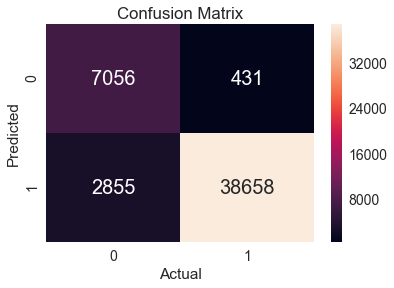

In [116]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, linear_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

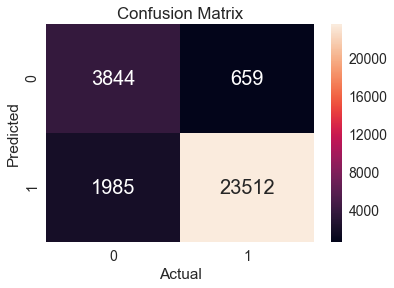

In [117]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, linear_svm.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [118]:
#Source:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
feature_names = tf_idf_vect.get_feature_names()
coefs_with_fns = sorted(zip(linear_svm.coef_[0], feature_names))
top = coefs_with_fns[:-(20 + 1):-1]
print("Top 10 positive features")
for coef_2, fn_2 in top:
    print("%s <------------------------>%s"%(coef_2, fn_2))

Top 10 positive features
6.2400669163114655 <------------------------>great
5.086554337111435 <------------------------>best
4.610325340660913 <------------------------>delicious
4.097377704255008 <------------------------>perfect
4.064551901888775 <------------------------>love
4.020541693651916 <------------------------>good
3.7960244567615073 <------------------------>loves
3.3545294722135464 <------------------------>excellent
3.045797483495308 <------------------------>wonderful
2.957107279336816 <------------------------>amazing
2.697876543278734 <------------------------>happy
2.6193610414432125 <------------------------>not disappointed
2.5237427790147446 <------------------------>favorite
2.4444931367884193 <------------------------>pleased
2.4419590938103073 <------------------------>awesome
2.4080861300618066 <------------------------>easy
2.3736096220987863 <------------------------>nice
2.283421253548524 <------------------------>tasty
2.2557382724121724 <-----------------

In [120]:
#Source:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
feature_names = tf_idf_vect.get_feature_names()
coefs_with_fns = sorted(zip(linear_svm.coef_[0], feature_names))
top = coefs_with_fns[:20]
print("Top 10 negative features")
for coef_1, fn_1 in top:
    print("%s    <---------------->     %s"%(coef_1, fn_1))


Top 10 negative features
-4.602924407064047    <---------------->     disappointed
-4.341696332541072    <---------------->     not
-3.6857879138100547    <---------------->     worst
-3.61463548268191    <---------------->     terrible
-3.333406559073328    <---------------->     awful
-3.307744303192963    <---------------->     not good
-3.1526551626257233    <---------------->     disappointing
-3.012357557504173    <---------------->     bland
-2.9912158695410325    <---------------->     not worth
-2.9592572896789817    <---------------->     unfortunately
-2.9310204048759703    <---------------->     not recommend
-2.7155645090633596    <---------------->     horrible
-2.700323411143955    <---------------->     thought
-2.683472026746276    <---------------->     stale
-2.5870988624895443    <---------------->     bad
-2.530688973460432    <---------------->     tasteless
-2.4883863627713194    <---------------->     rip
-2.4834567054383148    <---------------->     not buy
-2.

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [85]:
X=preprocessed_RevSum[:100000]
PosNeg = final['Score']
y=PosNeg[:100000]

In [86]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [87]:
# Preparing Reviews for gensim model
i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

In [88]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [89]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [90]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13556
sample words  ['thick', 'taste', 'like', 'real', 'movie', 'theater', 'popcorn', 'butter', 'not', 'salted', 'salt', 'perfect', 'topping', 'concern', 'no', 'expiration', 'date', 'container', 'need', 'know', 'long', 'shelf', 'life', 'unused', 'portion', 'customer', 'service', 'number', 'consumer', 'questions', 'enjoyed', 'tea', 'wooden', 'box', 'also', 'nice', 'lightweight', 'certainly', 'fancy', 'holder', 'took', 'get', 'used', 'chips', 'pretty', 'good', 'healthy', 'sure', 'eaten', 'family']


In [91]:
# Converting Reviews into Numerical Vectors using W2V vectors
from tqdm import tqdm
import numpy as np

In [92]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[5])

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [02:30<00:00, 326.31it/s]


(49000, 50)
[ 0.45456229 -0.59595331 -0.99683762  1.81329924 -0.93223165  0.35470177
 -1.01648596  0.09362013 -0.35284055 -0.50694093 -0.03805557  1.18516368
  0.20432668  0.60795203 -0.73913598  0.020856   -0.92536263 -0.32495231
  0.60742344  1.36277981 -1.82537229 -0.28431131 -0.25600004  0.49988437
  0.75164545 -0.05646833 -0.23240365  0.41404346 -0.19573949 -0.61414777
  0.44539932  0.61363425 -0.20554053  0.80014668 -0.21713538  1.08414626
  1.42403559 -1.34794586  1.48320175 -0.34969582 -0.20954852  0.17170624
 -0.6067173  -0.98718748  0.13923602 -1.04238468  1.38629802 -0.6029959
  0.60224321  0.72990786]


In [93]:
 # Converting CV data text
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [94]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [01:16<00:00, 275.49it/s]


(21000, 50)
[ 2.28781378e-01 -3.95791538e-01 -3.56354704e-01 -1.66019721e-01
 -2.59712535e-02 -1.10047898e-01  2.18988663e-02  1.99839092e-01
  1.53714241e-01 -2.08640200e-01 -3.00832138e-01 -4.35878616e-01
 -1.35008921e-01 -2.73695168e-01 -6.83668697e-01 -2.38227997e-01
 -6.45634356e-02 -4.73136475e-01 -3.50482286e-01  5.59977127e-01
 -7.71551930e-03  1.15247946e-01 -5.93214338e-01 -2.55447429e-02
  2.18425968e-01  2.69476790e-03 -1.35602036e-01 -2.55341519e-02
 -2.85837525e-01  4.85485926e-01 -1.84096059e-01 -2.51826091e-01
  6.78992254e-01  2.87100519e-01 -8.35921355e-02  1.28143667e-02
  3.48715187e-01 -5.34969824e-01  3.41969337e-01  4.35773882e-01
  4.01663770e-01 -9.75364349e-03 -2.45840554e-01 -3.02326329e-01
  1.08804891e+00 -3.53188399e-01  1.69995535e-04 -2.14788925e-02
  1.96342791e-01  2.80618728e-01]


In [95]:
# Converting Test data text
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())


In [96]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:43<00:00, 289.14it/s]


(30000, 50)
[ 0.47940388 -0.0410744  -0.1976545   0.41458283  1.16313418  0.29852743
  0.50222618  0.41400906  0.14724558 -0.03110447 -0.086029   -0.05645279
 -0.54123201 -0.18061138 -0.4898398  -0.1230266   0.09981246 -0.32493547
 -0.15825953  0.66199084  0.46522571 -0.37499997 -0.23470965 -0.65894833
  0.74676284 -0.06353698 -0.77402892  0.00802863 -0.11823956  0.06330578
  0.0332039  -0.17466114  0.67286499 -0.54236802  0.01117123  0.5192334
  0.84871424  0.20193774  0.97788441  0.02662429  0.87449527 -0.11205048
 -0.69826027 -0.01828125  0.76847835 -0.22877943  0.56441716 -0.14675017
  0.16636131  0.09830906]


In [97]:
X_tr = sent_vectors_train
X_cv = sent_vectors_cv
X_test = sent_vectors_test

In [98]:
alpha_values = []
powers = [-4,-3,-2,-1,0,1,2,3,4]
for i in powers:
    alpha_values.append(10**i)
print(alpha_values)   

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [99]:
from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C for l2 is %f.' % optimal_alpha)



The optimal C for l2 is 0.001000.


In [100]:
from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l1', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha1 = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C for l1 is %f.' % optimal_alpha1)


The optimal C for l1 is 0.001000.


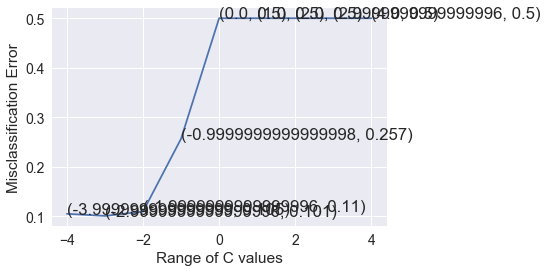

the misclassification error for each C value is :  [0.105 0.101 0.11  0.257 0.5   0.5   0.5   0.5   0.5  ]


In [101]:
import math
alpha = []
for i in alpha_values:
    alpha.append(math.log(i,10))

# plot misclassification error vs alpha
plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Range of C values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

In [102]:
linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier for of l2 Regularization C = %f is %f%%' % (optimal_alpha, AUC))


The AUC of the svm classifier for of l2 Regularization C = 0.001000 is 90.080707%


In [103]:
linear_svm = SGDClassifier(alpha=optimal_alpha1,penalty='l1', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier of l1 Regularization for C = %f is %f%%' % (optimal_alpha1, AUC))


The AUC of the svm classifier of l1 Regularization for C = 0.001000 is 90.011069%


* The best/optimal C for AVG-W2V using l1 regularization is 0.001 and its AUC is 90.01%.
* The best/optimal C for TF-IDF using l2 regularization is 0.001 and its AUC is 90.08%.
* Therefore AUC for l1 and l2 regularization are approzimately same.

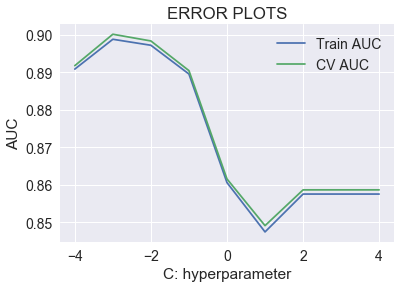

In [104]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3, 10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in C:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm)
    sig_clf.fit(X_tr,y_tr)

    # not the predicted outputs
    y_train_pred =  sig_clf.predict_proba(X_tr)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


import math
alpha = []
for i in C:
    alpha.append(math.log(i,10))

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

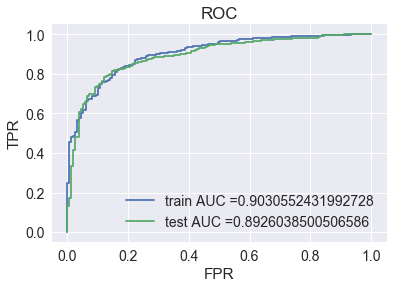

Test confusion matrix
[[ 5927  1611]
 [ 6493 34969]]
Test confusion matrix
[[ 3549   954]
 [ 3953 21544]]


In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm)
sig_clf.fit(X_tr,y_tr)


for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], sig_clf.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], sig_clf.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
print(confusion_matrix(y_tr, linear_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, linear_svm.predict(X_test)))

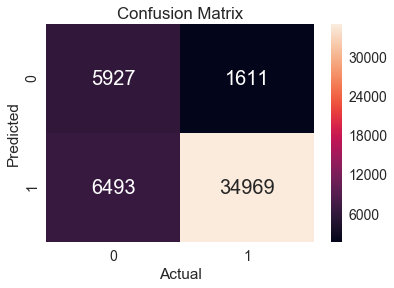

In [106]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, linear_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

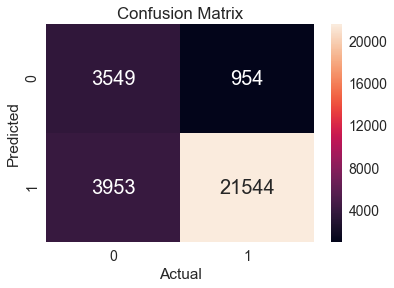

In [107]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, linear_svm.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [108]:
X=preprocessed_RevSum[:100000]
PosNeg = final['Score']
y=PosNeg[:100000]

In [109]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

In [110]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [111]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# Converting Reviews into Numerical Vectors using W2V vectors
from tqdm import tqdm
import numpy as np

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,2), min_df=10, dtype=np.float64,max_features = 500)
model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

X_tr = model.transform(X_tr)

 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

number of words that occured minimum 5 times  13466
sample words  ['great', 'buy', 'coffee', 'tasted', 'quite', 'fresh', 'much', 'better', 'deal', 'getting', 'grocery', 'store', 'recently', 'sent', 'senseo', 'pod', 'maker', 'good', 'looking', 'get', 'pods', 'read', 'lot', 'reviews', 'foward', 'plus', 'brand', 'sounds', 'like', 'would', 'taste', 'however', 'apparently', 'not', 'ship', 'alaska', 'least', 'said', 'location', 'since', 'gotten', 'items', 'amazon', 'assume', 'disappointing', 'reading', 'many', 'bit', 'enjoyed', 'though']


100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [02:57<00:00, 275.59it/s]


In [112]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [113]:
X_cv = model.transform(X_cv)

In [114]:
 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [01:05<00:00, 322.15it/s]


In [115]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [116]:
X_test = model.transform(X_test)

In [117]:
 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:24<00:00, 355.09it/s]


In [118]:
X_tr = tfidf_sent_vectors_train
X_cv = tfidf_sent_vectors_cv
X_test = tfidf_sent_vectors_test

X_tr = np.array(X_tr)
X_cv = np.array(X_cv)
X_test = np.array(X_test)

In [119]:
alpha_values = []
powers = [-4,-3,-2,-1,0,1,2,3,4]
for i in powers:
    alpha_values.append(10**i)
print(alpha_values)   

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [120]:
from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C for l2 Regularization is %f.' % optimal_alpha)



The optimal C for l2 Regularization is 0.010000.


In [121]:
from sklearn.calibration import CalibratedClassifierCV

# empty list that will hold AUC scores
AUC_scores = []


for i in alpha_values:
    linear_svm = SGDClassifier(alpha=i,penalty='l1', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
    sig_clf.fit(X_tr,y_tr)
    y_cv_prob =  []
    for i in range(0,X_cv.shape[0],1000):
        y_cv_prob.extend(sig_clf.predict_proba(X_cv[i:i+1000])[:,1])
    

    AUC_scores.append(roc_auc_score(y_cv,y_cv_prob).mean())

# changing to misclassification error
MSE = [1 - x for x in AUC_scores]

# determining best alpha
optimal_alpha1 = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal C for l1 Regularization is %f.' % optimal_alpha1)



The optimal C for l1 Regularization is 0.001000.


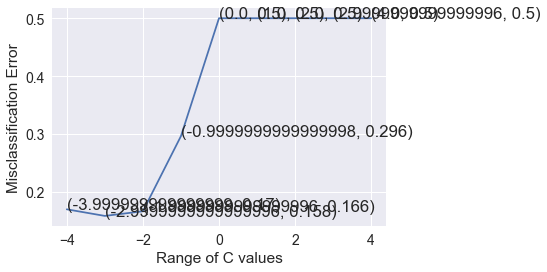

the misclassification error for each C value is :  [0.17  0.158 0.166 0.296 0.5   0.5   0.5   0.5   0.5  ]


In [122]:
import math
alpha = []
for i in alpha_values:
    alpha.append(math.log(i,10))

# plot misclassification error vs alpha
plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Range of C values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

In [123]:
linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier of l2 Regularization for C = %f is %f%%' % (optimal_alpha, AUC))


The AUC of the svm classifier of l2 Regularization for C = 0.010000 is 84.800627%


In [124]:
linear_svm = SGDClassifier(alpha=optimal_alpha1,penalty='l1', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm, method="sigmoid")
sig_clf.fit(X_tr,y_tr)




# evaluate AUC
AUC = roc_auc_score(y_test,sig_clf.predict_proba(X_test)[:,1]) * 100
print('\nThe AUC of the svm classifier of l1 Regularization for C = %f is %f%%' % (optimal_alpha1, AUC))


The AUC of the svm classifier of l1 Regularization for C = 0.001000 is 84.313448%


* The best/optimal C for TF-IDF-W2v using l1 regularization is 0.001 and its AUC is 84.3%.
* The best/optimal C for TF-IDF-W2v using l2 regularization is 0.01 and its AUC is 84.80%.
* Therefore  AUC for l1 and l2 regularization are equal.

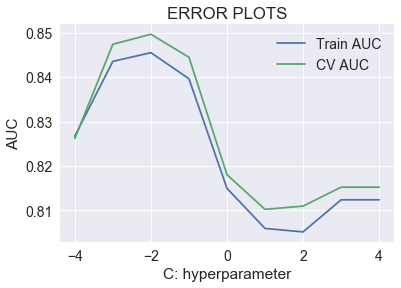

In [159]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3, 10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in C:
    linear_svm = SGDClassifier(alpha=i,penalty='l2', loss='hinge',class_weight = 'balanced')
    linear_svm.fit(X_tr,y_tr)    

    sig_clf = CalibratedClassifierCV(linear_svm)
    sig_clf.fit(X_tr,y_tr)

    # not the predicted outputs
    y_train_pred =  sig_clf.predict_proba(X_tr)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


import math
alpha = []
for i in C:
    alpha.append(math.log(i,10))

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

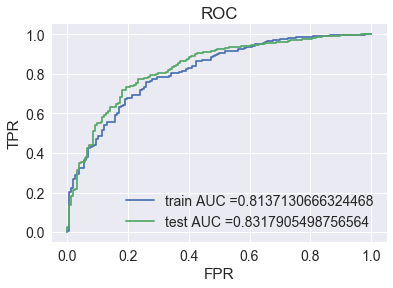

Test confusion matrix
[[ 6136  1289]
 [12291 29284]]
Test confusion matrix
[[ 3744   759]
 [ 7459 18038]]


In [160]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

linear_svm = SGDClassifier(alpha=optimal_alpha,penalty='l2', loss='hinge',class_weight = 'balanced')
linear_svm.fit(X_tr,y_tr)    

sig_clf = CalibratedClassifierCV(linear_svm)
sig_clf.fit(X_tr,y_tr)


for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], sig_clf.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], sig_clf.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
print(confusion_matrix(y_tr, linear_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, linear_svm.predict(X_test)))

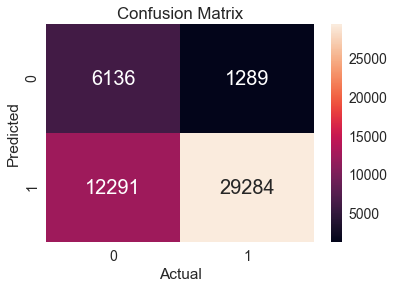

In [161]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, linear_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

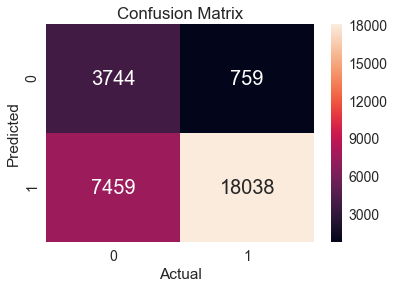

In [162]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, linear_svm.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [36]:
#For Feature Engineering
df1 = pd.DataFrame(preprocessed_RevSum)
docs =preprocessed_RevSum
data = []
for d in docs:
    
    data.append(len(d))

df1['length'] = data
df1.head(5)

,0,length
0,remembered book childhood got kids good rememb...,114
1,daughter loves really rosie books introduced r...,285
2,one best children books ever written mini vers...,144
3,entertaining rhyming story cleaver catchy illu...,142
4,grand daughter favorite book read loves rhythm...,80


In [37]:
docs =preprocessed_RevSum
data = []
for d in docs:
    
    data.append(len(d))

In [38]:
df1['length'] = data
df1.head(5)

,0,length
0,remembered book childhood got kids good rememb...,114
1,daughter loves really rosie books introduced r...,285
2,one best children books ever written mini vers...,144
3,entertaining rhyming story cleaver catchy illu...,142
4,grand daughter favorite book read loves rhythm...,80


In [39]:
df1 = df1.rename(columns = {0 : 'preprocessed_RevSum'})
df1.head(3)

,preprocessed_RevSum,length
0,remembered book childhood got kids good rememb...,114
1,daughter loves really rosie books introduced r...,285
2,one best children books ever written mini vers...,144


In [294]:
X=df1[:40000]
PosNeg = final['Score']
y=PosNeg[:40000]

In [295]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [296]:
type(X_tr)

pandas.core.frame.DataFrame

In [297]:
#performing bow
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(X_tr['preprocessed_RevSum'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_tr['preprocessed_RevSum'].values)
X_cv_bow = vectorizer.transform(X_cv['preprocessed_RevSum'].values)
X_test_bow = vectorizer.transform(X_test['preprocessed_RevSum'].values)

print("After vectorizations")
print(X_train_bow.shape, y_tr.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)


(19600, 2) (19600,)
(8400, 2) (8400,)
(12000, 2) (12000,)
After vectorizations
(19600, 11716) (19600,)
(8400, 11716) (8400,)
(12000, 11716) (12000,)


In [298]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(19600, 1) (19600,)
(8400, 1) (8400,)
(12000, 1) (12000,)


*Feature Engineering*


In [299]:
# Feature Engineering
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_bow,X_train_price_norm)).tocsr()
X_cv = hstack((X_cv_bow, X_cv_price_norm)).tocsr()
X_test = hstack((X_test_bow, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

Final Data matrix
(19600, 11717) (19600,)
(8400, 11717) (8400,)
(12000, 11717) (12000,)


In [300]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC



tuned_parameters = {'C': [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_svm = SVC(kernel = 'rbf',class_weight='balanced')

#Using GridSearchCV
model = GridSearchCV(rbf_svm, tuned_parameters, scoring = 'roc_auc',cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print("AUC is ",model.score(X_test, y_test))


SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
AUC is  0.9358035887942651


In [301]:
optimal_c = model.best_estimator_.C
print(optimal_c)

100


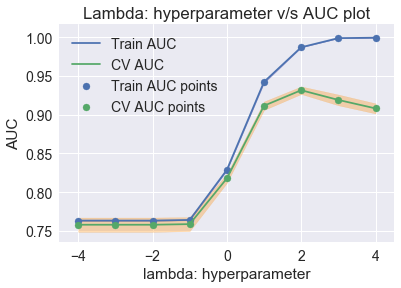

In [302]:


train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']
import math
C = []
for i in tuned_parameters['C']:
    C.append(math.log(i,10))

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()


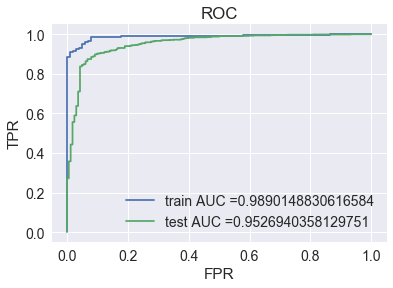

Train confusion matrix
[[ 2790    94]
 [ 1171 15545]]
Test confusion matrix
[[1497  311]
 [ 897 9295]]


In [304]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rbf_svm = SVC(kernel = 'rbf',class_weight='balanced',C = optimal_c ,probability=True)
rbf_svm.fit(X_tr,y_tr)    



for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], rbf_svm.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], rbf_svm.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rbf_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rbf_svm.predict(X_test)))

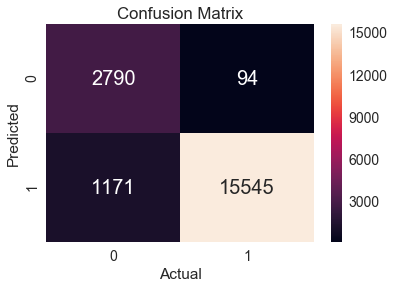

In [305]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, rbf_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

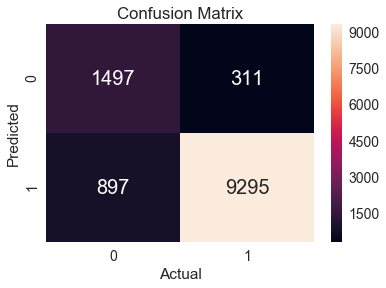

In [306]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, rbf_svm.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [40]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score

In [41]:
X=df1[:40000]
PosNeg = final['Score']
y=PosNeg[:40000]

In [42]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [43]:
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,dtype=np.float64,max_features=500)
tf_idf_vect.fit(X_tr['preprocessed_RevSum'].values)
X_tr_tfidf= tf_idf_vect.transform(X_tr['preprocessed_RevSum'].values)
X_cv_tfidf = tf_idf_vect.transform(X_cv['preprocessed_RevSum'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['preprocessed_RevSum'].values)
print("After vectorizations")
print(X_tr_tfidf.shape, y_tr.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


(19600, 2) (19600,)
(8400, 2) (8400,)
(12000, 2) (12000,)
After vectorizations
(19600, 500) (19600,)
(8400, 500) (8400,)
(12000, 500) (12000,)


In [44]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['length'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['length'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['length'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['length'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(19600, 1) (19600,)
(8400, 1) (8400,)
(12000, 1) (12000,)


*Feature Engineering*


In [45]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_tr_tfidf,X_train_price_norm)).tocsr()
X_cv = hstack((X_cv_tfidf, X_cv_price_norm)).tocsr()
X_test = hstack((X_test_tfidf, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


Final Data matrix
(19600, 501) (19600,)
(8400, 501) (8400,)
(12000, 501) (12000,)


In [47]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


tuned_parameters = {'C': [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_svm = SVC(kernel = 'rbf',class_weight='balanced',probability = True)

#Using GridSearchCV
model = GridSearchCV(rbf_svm, tuned_parameters, scoring = 'roc_auc',cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print("AUC is ",model.score(X_test, y_test))


SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
AUC is  0.9047914987982941


In [48]:
optimal_c = model.best_estimator_.C
print(optimal_c)

100


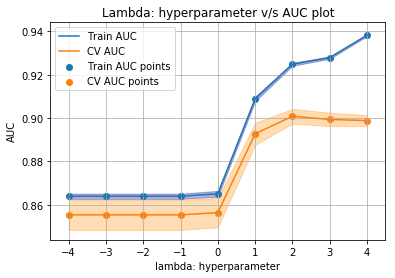

In [49]:

train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']
import math
C = []
for i in tuned_parameters['C']:
    C.append(math.log(i,10))

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()


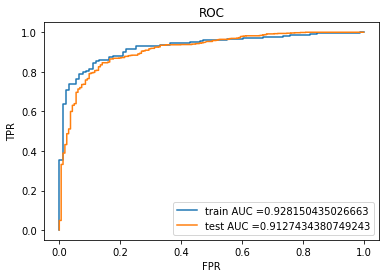

Train confusion matrix
[[ 2482   367]
 [ 3020 13731]]
Test confusion matrix
[[1517  291]
 [1920 8272]]


In [51]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rbf_svm = SVC(kernel = 'rbf',class_weight='balanced',C = optimal_c ,probability=True)
rbf_svm.fit(X_tr,y_tr)    




for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], rbf_svm.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], rbf_svm.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rbf_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rbf_svm.predict(X_test)))

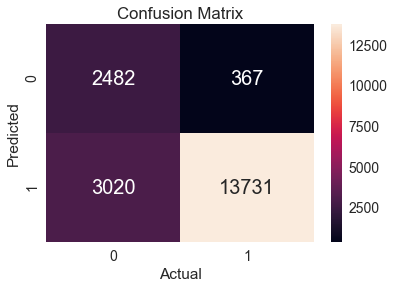

In [52]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, rbf_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

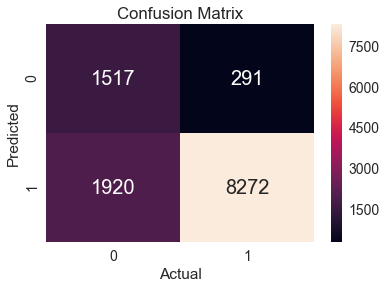

In [53]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, rbf_svm.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [246]:
X=preprocessed_RevSum[:40000]
PosNeg = final['Score']
y=PosNeg[:40000]

In [247]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


In [248]:
# Preparing Reviews for gensim model
i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

In [249]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [250]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [251]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8528
sample words  ['recently', 'paid', 'size', 'packs', 'product', 'pretty', 'good', 'kind', 'dal', 'sort', 'thing', 'cannot', 'see', 'look', 'elsewhere', 'bars', 'roll', 'types', 'hard', 'eat', 'actually', 'part', 'like', 'much', 'take', 'effort', 'bite', 'chew', 'basically', 'force', 'slower', 'result', 'feel', 'satisfied', 'end', 'eating', 'one', 'candy', 'bar', 'three', 'bites', 'not', 'find', 'rocks', 'though', 'chewy', 'food', 'definitely', 'also', 'really']


In [252]:
# Converting Reviews into Numerical Vectors using W2V vectors
from tqdm import tqdm
import numpy as np

In [253]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[5])

100%|███████████████████████████████████████████████████████████████████████████| 19600/19600 [00:40<00:00, 483.18it/s]


(19600, 50)
[ 8.50167658e-01  9.77929599e-01  5.25538497e-01 -4.51385543e-01
 -2.50978012e-01 -9.75918448e-01 -4.62181980e-01 -1.38181987e-01
  7.03726654e-04  9.67358029e-02 -8.60637232e-01  2.77434798e-01
  4.37127071e-01 -1.03834791e+00 -3.96292879e-01 -7.37307203e-02
 -9.95452343e-04  1.06901220e-01  1.03579963e+00 -6.90404336e-01
 -6.38555690e-02 -1.33623885e-01  3.61866801e-01 -1.09471068e-01
  2.51027576e-02  1.11244806e-01 -3.50145511e-01 -3.73951585e-01
 -1.15085336e-01  1.01540686e-01 -7.66264051e-02 -3.43921381e-01
 -5.67871893e-01  8.01103622e-02 -1.13546385e+00 -5.98712057e-01
 -6.40477654e-01 -4.63804245e-01  2.15504975e-01 -3.37378653e-01
  6.01306665e-02  1.34400534e-01 -8.66489492e-01  5.21766865e-01
  7.13197864e-01  3.94113088e-01 -6.91491689e-01 -4.53593346e-01
  3.88651910e-01  9.84714454e-01]


In [254]:
# Converting CV data text
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [255]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 8400/8400 [00:17<00:00, 468.33it/s]


(8400, 50)
[-0.00463006  0.42967155  0.36775022 -0.19988334 -0.47774863 -0.63230179
 -0.30613277 -0.53311443  0.21797744  0.45725102 -0.49041738 -0.26550037
  0.2567979   0.17224269 -0.08471014 -0.79676595  0.23128922  0.21038679
 -0.01518148 -0.20765785 -0.5098009  -0.74314364  0.07781033  0.03341112
  0.41020715  0.21343065  0.2710939   0.06638408 -0.13972348 -0.43100378
  0.33760763  0.29323077 -0.19396689 -0.18643703 -0.79559585  0.10333422
 -0.59438457 -0.20829112  0.44772933 -0.08668327 -0.43404284 -0.3561928
 -0.87595492 -0.0813289   0.60177392  0.37381144 -0.41882675 -0.17794604
  0.19841689 -0.05288799]


In [256]:
# Converting Test data text
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())


In [257]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:25<00:00, 467.72it/s]


(12000, 50)
[-0.21611016  0.51633282  0.23650096 -0.00509073 -0.29359519 -0.5242995
 -0.49134835 -0.76123449  0.45226292  0.81047029 -0.50167005 -0.24146431
  0.59866127  0.51015858 -0.44742048 -0.69738546  0.46860145  0.08422847
 -0.69323207 -0.92045076 -0.60487609 -1.13789011  0.820331    0.28647423
  0.7315446  -0.03401961 -0.11770777  0.51414262  0.21167859 -0.46970857
  0.95250349  0.27979053  0.18389152 -0.80416813 -0.69050033  0.1957202
 -0.69569083 -0.31629739 -0.09036234 -0.03204443 -0.24317997 -0.54117761
 -0.69808686 -0.34899874 -0.12753345  0.88314482 -0.48546589 -0.44288765
 -0.1154689   0.12207212]


In [258]:
X_tr = sent_vectors_train
X_cv = sent_vectors_cv
X_test = sent_vectors_test

In [259]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



tuned_parameters = {'C': [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_svm = SVC(kernel = 'rbf',class_weight='balanced',probability = True)

#Using GridSearchCV
model = GridSearchCV(rbf_svm, tuned_parameters, scoring = 'roc_auc',cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print("AUC is ",model.score(X_test, y_test))


SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
AUC is  0.8892793215397119


In [260]:
optimal_c = model.best_estimator_.C
print(optimal_c)

100


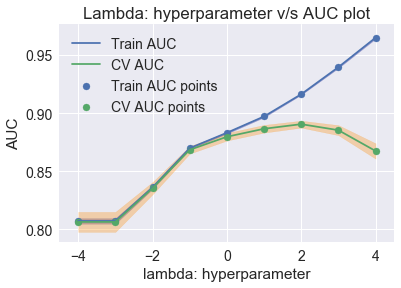

In [261]:

train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']
import math
C = []
for i in tuned_parameters['C']:
    C.append(math.log(i,10))

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()

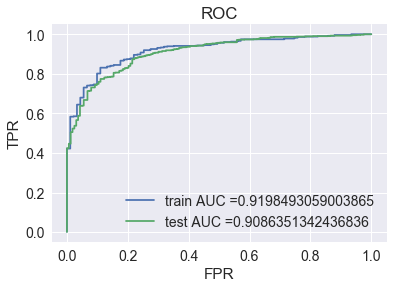

Train confusion matrix
[[ 2534   302]
 [ 3459 13305]]
Test confusion matrix
[[1510  298]
 [2191 8001]]


In [262]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rbf_svm = SVC(kernel = 'rbf',class_weight='balanced',C = optimal_c ,probability=True)
rbf_svm.fit(X_tr,y_tr)    



for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], rbf_svm.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], rbf_svm.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rbf_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rbf_svm.predict(X_test)))

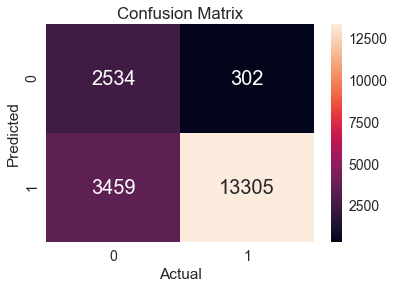

In [263]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, rbf_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

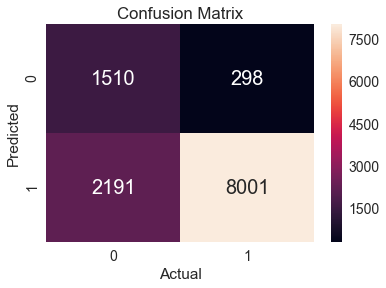

In [264]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, rbf_svm.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [265]:
X=preprocessed_RevSum[:40000]
PosNeg = final['Score']
y=PosNeg[:40000]

In [266]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

i=0
list_of_sentance_train=[]
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())
    
    

In [267]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [268]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# Converting Reviews into Numerical Vectors using W2V vectors
from tqdm import tqdm
import numpy as np

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,2), min_df=10, dtype=np.float64,max_features = 500)
model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

X_tr = model.transform(X_tr)

 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

number of words that occured minimum 5 times  8536
sample words  ['love', 'thought', 'would', 'try', 'sugar', 'free', 'version', 'not', 'eat', 'make', 'think', 'dying', 'worst', 'gas', 'pains', 'ever', 'ate', 'within', 'two', 'hours', 'doubled', 'pain', 'please', 'put', 'regular', 'ones', 'basically', 'clean', 'eater', 'every', 'like', 'something', 'sweet', 'never', 'cat', 'suffers', 'hairballs', 'spring', 'shedding', 'season', 'read', 'squash', 'pumpkin', 'baby', 'food', 'helps', 'add', 'fiber', 'cats', 'diet']


100%|███████████████████████████████████████████████████████████████████████████| 19600/19600 [01:06<00:00, 295.28it/s]


In [269]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [270]:
X_cv = model.transform(X_cv)

In [271]:
 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 8400/8400 [00:30<00:00, 347.99it/s]


In [272]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [273]:
X_test = model.transform(X_test)

In [274]:
 #TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:42<00:00, 283.66it/s]


In [275]:
X_tr = tfidf_sent_vectors_train
X_cv = tfidf_sent_vectors_cv
X_test = tfidf_sent_vectors_test

X_tr = np.array(X_tr)
X_cv = np.array(X_cv)
X_test = np.array(X_test)

In [276]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



tuned_parameters = {'C': [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
rbf_svm = SVC(kernel = 'rbf',class_weight='balanced',probability = True)

#Using GridSearchCV
model = GridSearchCV(rbf_svm, tuned_parameters, scoring = 'roc_auc',cv=5)
model.fit(X_tr, y_tr)

print(model.best_estimator_)
print("AUC is ",model.score(X_test, y_test))


SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
AUC is  0.8527273853082756


In [277]:
optimal_c = model.best_estimator_.C
print(optimal_c)

10


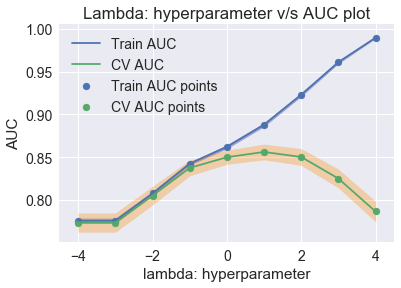

In [278]:

train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']
import math
C = []
for i in tuned_parameters['C']:
    C.append(math.log(i,10))

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("Lambda: hyperparameter v/s AUC plot")
plt.grid(True)
plt.show()

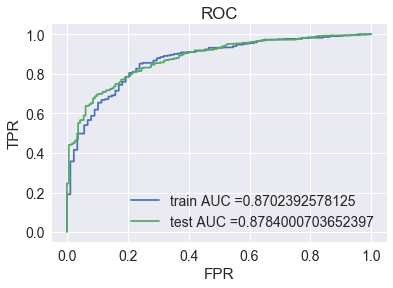

Train confusion matrix
[[ 2435   442]
 [ 3858 12865]]
Test confusion matrix
[[1440  368]
 [2484 7708]]


In [279]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rbf_svm = SVC(kernel = 'rbf',class_weight='balanced',C = optimal_c ,probability=True)
rbf_svm.fit(X_tr,y_tr)    



for i in range(0,X_tr.shape[0],1000):
    train_fpr, train_tpr, thresholds = roc_curve(y_tr[i:i+1000], rbf_svm.predict_proba(X_tr[i:i+1000])[:,1])

for i in range(0,X_test.shape[0],1000):
    test_fpr, test_tpr, thresholds = roc_curve(y_test[i:i+1000], rbf_svm.predict_proba(X_test[i:i+1000])[:,1])    

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rbf_svm.predict(X_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rbf_svm.predict(X_test)))

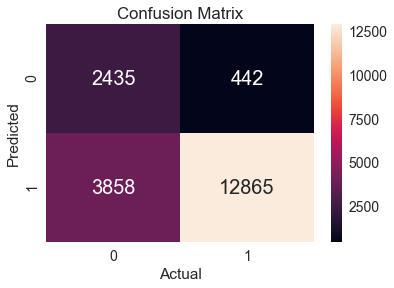

In [280]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_tr, rbf_svm.predict(X_tr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

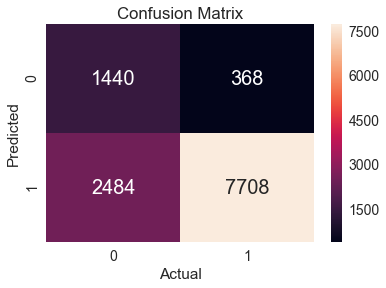

In [281]:
confusion_mtx = pd.DataFrame(confusion_matrix(y_test, rbf_svm.predict(X_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_mtx, annot=True,annot_kws={"size": 20}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# [6] Conclusions

In [143]:
from prettytable import PrettyTable
PTable = PrettyTable()
PTable.field_names = ["Vectorizor", " Model", "Hyperparameter--C", "Test-AUC","Train-AUC"]
from prettytable import PrettyTable
PTable1 = PrettyTable()
PTable1.field_names = ["Vectorizor", " Model", "Hyperparameter--C", "Test-AUC","Train-AUC"]

In [144]:
PTable.add_row(['BoW','Linear SVM',0.001,0.93,0.98])
PTable.add_row(['TF-IDF','Linear SVM',0.0001,0.94,0.99])
PTable.add_row(['AVG-W2V','Linear SVM',0.001,0.89,0.91])
PTable.add_row(['TFIDF_W2V','Linear SVM',0.01,0.83,0.81])
print(PTable)
PTable1.add_row(['BOW','RBF_SVM',100,0.95,0.98])
PTable1.add_row(['TF-IDF','RBF_SVM',100,0.91,0.92])
PTable1.add_row(['AVG-W2V','RBF_SVM',100,0.90,0.91])
PTable1.add_row(['TFIDF_W2V','RBF_SVM',10,0.85,0.87])
print(PTable1)

+------------+------------+-------------------+----------+-----------+
| Vectorizor |    Model   | Hyperparameter--C | Test-AUC | Train-AUC |
+------------+------------+-------------------+----------+-----------+
|    BoW     | Linear SVM |       0.001       |   0.93   |    0.98   |
|   TF-IDF   | Linear SVM |       0.0001      |   0.94   |    0.99   |
|  AVG-W2V   | Linear SVM |       0.001       |   0.89   |    0.91   |
| TFIDF_W2V  | Linear SVM |        0.01       |   0.83   |    0.81   |
+------------+------------+-------------------+----------+-----------+
+------------+---------+-------------------+----------+-----------+
| Vectorizor |   Model | Hyperparameter--C | Test-AUC | Train-AUC |
+------------+---------+-------------------+----------+-----------+
|    BOW     | RBF_SVM |        100        |   0.95   |    0.98   |
|   TF-IDF   | RBF_SVM |        100        |   0.91   |    0.92   |
|  AVG-W2V   | RBF_SVM |        100        |   0.9    |    0.91   |
| TFIDF_W2V  | RBF_SVM |

* The best/optimal C for BOW using l1 regularization is 0.0001 and its AUC is 93.6%.
* The best/optimal C for BOW using l2 regularization is 0.001 and its AUC is 95.09%.
* Therefore we got better AUC for l2 regularization.

* The best/optimal C for TF-IDF using l1 regularization is 0.0001 and its AUC is 94.4%.
* The best/optimal C for TF-IDF using l2 regularization is 0.0001 and its AUC is 95.80%.
* Therefore we got better AUC for l2 regularization

* The best/optimal C for AVG-W2V using l1 regularization is 0.001 and its AUC is 90.01%.
* The best/optimal C for TF-IDF using l2 regularization is 0.001 and its AUC is 90.08%.
* Therefore AUC for l1 and l2 regularization are approximately same.

* The best/optimal C for TF-IDF-W2v using l1 regularization is 0.001 and its AUC is 84.3%.
* The best/optimal C for TF-IDF-W2v using l2 regularization is 0.01 and its AUC is 84.80%.
* Therefore  AUC for l1 and l2 regularization are equal.

In Linear SVM better AUC score is obtained fow BOW and TFIDF featurizations compared to W2V and TFIDF_W2V.
For SVM using RBF kernal TFIDF_W2V got less auc than other featurizations.

# Procedure

* First I loaded the data from SQLite Database.

2. Data Cleaning: 
Deduplication - duplicates are removed

3. Preprocessing: 
It is done to remove html tags, punctuations or limited set of special characters ,Stopwords etc.
Preprocessing is performed on review text and summary text.

* In this analysis Linear SVM and SVM with RBF kernel  is applied on Bag of Words,TF-IDF,Avg-W2v,TFIDF-W2v vectorizers.
2. Firstly I created new dataframe (df1), where i used only preprocessed review and preprocessed summary text as a seperate column.
3. For each reviews I created a new feature - length(which computes length of review text).
4. Then I created a new column for length feature in the dataframe.
5. Considering only 100k data points I spllited the data into 3 parts -Train,Cv,Test.
6. SVM using 'SGDClassifier' with hinge loss is used because it is computationally less expensive with "l1" and "l2" Regularization,fitted the D_train data.
8. Here only 500 features and 40k data points are taken in case of BOW and TFIDF(for SVM_RBF) because computationally more expensive.
7. Using for loops and Gridsearchcv,I computed best hyperparameter(C) for each featurization.
12. The plotted Error and Auc plots.
11. Then computed top 10 features for both positive and negative weights for BOW and TFIDF.
13. Confusion matrix (for both train and test)is obtained for every featurizations.
14. We can further improve the model by taking more data points, and by taking some other features that may provide us with better insight about the data.
 